In this notebook we do data preparation. 

We start by installing the necessary packages

In [24]:
import os
from torch_snippets import torch, read, randint, Dataset, write, plt
from pathlib import PurePath
import numpy as np
from math import cos, sin
import matplotlib
from matplotlib.patches import Polygon
from tqdm import notebook
from glob import glob
import csv
from PoissonDiskSampling import PoissonDiskSampling
from cropRotatedSquare import cropRotatedSquare
import random 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We start by reading all the GINI files and building a map from file name to file location. We will need this map so that we can augment the 'garbage-queried-images.csv' file with file locations in addition to the bounding boxes it originally contained. Both the path and the folder name just beneath the actual image file is included. The folder name gives a kind of class label. The boolean at the end of each list tells if the image is garbage or non-garbage

In [2]:
name2path = {}

paths = [y for x in os.walk('spotgarbage-GINI-master\spotgarbage\garbage-queried-images') for y in glob(os.path.join(x[0], '*.*'))]
for path in paths:
    pure = PurePath(path)
    name2path[pure.name] = [path,pure.parts[-2],True]

paths = [y for x in os.walk('spotgarbage-GINI-master\spotgarbage\\non-garbage-queried-images') for y in glob(os.path.join(x[0], '*.*'))]
for path in paths:
    pure = PurePath(path)
    name2path[pure.name] = [path,pure.parts[-2],False] 

In [3]:
name2path.keys()

dict_keys(['398faec8-6799-11e5-8dc4-40f2e96c8ad8.jpg', '3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg', '46e3e5ee-6799-11e5-8dc4-40f2e96c8ad8.jpg', '47e1b9a8-6799-11e5-8dc4-40f2e96c8ad8.jpg', '495f1dca-6799-11e5-8dc4-40f2e96c8ad8.jpg', '4c3d9cb0-6799-11e5-8dc4-40f2e96c8ad8.jpg', '4c6794ac-6799-11e5-8dc4-40f2e96c8ad8.jpg', '4c942aee-6799-11e5-8dc4-40f2e96c8ad8.jpg', '894d0654-6799-11e5-8dc4-40f2e96c8ad8.jpg', '8c1b5552-6799-11e5-8dc4-40f2e96c8ad8.jpg', '8d1faf66-6799-11e5-8dc4-40f2e96c8ad8.jpg', '911108a4-6799-11e5-ba3c-40f2e96c8ad8.jpg', '9282d0c8-6799-11e5-ba3c-40f2e96c8ad8.jpg', '92cc9866-6799-11e5-ba3c-40f2e96c8ad8.jpg', '92ff7cae-6799-11e5-ba3c-40f2e96c8ad8.jpg', '93a3926c-6799-11e5-ba3c-40f2e96c8ad8.jpg', '95a65b44-6799-11e5-ba3c-40f2e96c8ad8.jpg', '96137d1e-6799-11e5-ba3c-40f2e96c8ad8.jpg', '96463dda-6799-11e5-ba3c-40f2e96c8ad8.jpg', '967550c0-6799-11e5-ba3c-40f2e96c8ad8.jpg', '96a096ea-6799-11e5-ba3c-40f2e96c8ad8.jpg', '99ba1928-6799-11e5-ba3c-40f2e96c8ad8.jpg', '9aca41b2-6799-11e5-b

We now read the 'garbage-queried-images.csv' file and build a similar dictionary to the class label and bounding boxes. We skip the first row as this is where the column names are. There are no bounding boxes for non-garbage images, so we just put in None there

In [4]:
name2bounding = {}

with open('spotgarbage-GINI-master\spotgarbage\garbage-queried-images.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if row[3] != '' and row[4] != '' and row[5] != '' and row[6] != '':
            name2bounding[row[0]] = [row[1],row[3],row[4],row[5],row[6],True]

with open('spotgarbage-GINI-master\spotgarbage\\non-garbage-queried-images.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        name2bounding[row[0]] = [row[1],None,None,None,None,False]

Now we will join name2path and name2bounding into one dictionary and save as CSV for later use.

In [5]:
name2info = {}
for fileName in name2path:
    if fileName in name2bounding:
        name2info[fileName] = name2path[fileName] + name2bounding[fileName]

We store our new dictionary in a CSV file

In [6]:
with open('spotgarbage-GINI-master\spotgarbage\image-meta-data.csv', 'w', newline="") as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image','path','class','is Garbage','class','bounding box','is Garbage'])
    for fileName in name2info:
        writer.writerow([fileName] + name2info[fileName])

And lets read the Dictionary again, so we can use it for making the DataLoader

In [7]:
name2info = {}
with open('spotgarbage-GINI-master\spotgarbage\image-meta-data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(reader)
    for row in reader:
        name2info[row[0]] = row[1:]

Now we have enough structure to create our Dataset

In [8]:
class GINIdata(Dataset):
    def __init__(self, aug=None):
        self.name2info = []
        with open('spotgarbage-GINI-master\spotgarbage\image-meta-data.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='"')
            next(reader)
            for row in reader:
                name = row[0]
                if  PurePath(name).suffix != '.gif':
                    self.name2info.append(row)
        self.aug = aug
    def __len__(self):
        return len(self.name2info)
    def __getitem__(self, ix):
        name         = self.name2info[ix][0]
        path         = self.name2info[ix][1]
        garbageClass = self.name2info[ix][2]
        isGarbage    = (self.name2info[ix][3] == 'True')
        boundingBox  = [self.name2info[ix][5],self.name2info[ix][6],self.name2info[ix][7],self.name2info[ix][8]]
        image        = read(path,1)
        return image, boundingBox, garbageClass, isGarbage, name
    def choose(self): return self[randint(len(self))]

In [9]:
gini = GINIdata()

Now that we have easy access to our images we will generate the patches as described in the paper. The method is as follows:

a) Generate some Poisson disk samples with stride 9.1% of smaller image dimension

b) For each sample (a square with length 10%, 20%, 40% or 70% smaller image dimension) generate a random rotation

c) Find out if our sample fits into the image when the center of sample is the Poisson random disk center

d) If it does not fit shift it so that it just does

We create a utility function that takes an image dimensions (h,w), rotation angle (a), Poisson disk centre (x,y) and patch size (d) as inputs and generates an output that is modified if it does not fit into the image so that it just fits

In [10]:
def fitPatch(h, w, a, y, x, d):
    # Find bounding box size
    d1 = d * (np.cos(a) + np.sin(a))
    
    # correct x and y if needed
    x = d1/2     if x - d1/2 < 0 else x
    x = w - d1/2 if x + d1/2 > w else x
    y = d1/2     if y - d1/2 < 0 else y
    y = h - d1/2 if y + d1/2 > h else y

    return x, y

TODO: check that we use the boundingBox variable below and not the image itself, unless there is no bounding box

In [13]:
if not os.path.exists('spotgarbage-GINI-master\spotgarbage\patches'):
    os.mkdir("spotgarbage-GINI-master\spotgarbage\patches")
    # We have to seed both the numpy random generator and the one in the random module
    np.random.seed(42)
    random.seed(42)
    patch_size_factors0 = [0.1, 0.2, 0.4, 0.7] # patch size in proportion to minimal image dimension
    default_patch_num = [75, 19, 4, 2] # default number of patches for each size above
    patch_size_factors = [] # for each patch, its relative size
    N = 4 # number of random rotations per patch
    for j in range(len(patch_size_factors0)):
        patch_size_factors = patch_size_factors + [patch_size_factors0[j] for _ in range(default_patch_num[j])] 
   
    for i in notebook.tnrange(len(gini), desc='patches'):
        image, boundingBox, garbageClass, isGarbage, name = gini[i]

        # If the image is a garbage image we will need to crop it to its bounding box
        if isGarbage:
            boundingBox = [int(x) for x in boundingBox]
            height, width = boundingBox[3] - boundingBox[1], boundingBox[2] - boundingBox[0]
            image = image[boundingBox[1]:boundingBox[3], boundingBox[0]:boundingBox[2]] # crop image
        else:
            height, width = image.shape[0],image.shape[1]

        smaller_dim = min(height, width)
        patch_sizes = [x * smaller_dim for x in patch_size_factors] # for each patch, its absolute size
        samples = PoissonDiskSampling(width, height, smaller_dim * 0.091)
        nof_samples = min(100,len(samples))
        patch_sizes = patch_sizes[0:nof_samples] 
        patch_num = default_patch_num # actual number of patches for each size in patch_size_factors0
        patch_num[0] = default_patch_num[0] - (100 - nof_samples) # reduce the number of the smallest square patches
        samples = random.sample(samples,nof_samples)
        randomRotations = [random.uniform(0.0, np.pi / 2) for _ in range(4 * nof_samples)]
        for j in range(nof_samples):
            samples[j] = fitPatch(height, width, randomRotations[j], samples[j][1], samples[j][0], patch_sizes[j])

        # calculate the corner points of each patch square and crop the image (OpenCV operations)
        for j in range(N * nof_samples):
            x, y = samples[j % N]
            theta = randomRotations[j]
            rot = -np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
            corners = [
                [  patch_sizes[j % N]/2,   patch_sizes[j % N]/2],
                [  patch_sizes[j % N]/2, - patch_sizes[j % N]/2],
                [- patch_sizes[j % N]/2,   patch_sizes[j % N]/2],
                [- patch_sizes[j % N]/2, - patch_sizes[j % N]/2]]

            rotated = [[np.dot(rot, r) + [x,y]] for r in corners]
            rotated = np.array([[[int(c[0]),int(c[1])] for c in row] for row in rotated])

            # The rotated array contains the corners of the cropping square, so now we
            # do the cropping
            cropped = cropRotatedSquare(image, rotated)
            write(cropped,f'spotgarbage-GINI-master/spotgarbage/patches/{name}_{j}.png')

print('done')

patches:   0%|          | 0/1894 [00:00<?, ?it/s]

done


Let us visualize our patches so we can get an understanding of both the distribution of Poisson disks and validate that they are all within the image boundary. We calculate the rectangles both directly from the angles and from the polygon vectors of 4 corner points that are generated inside the loop for patch generation.

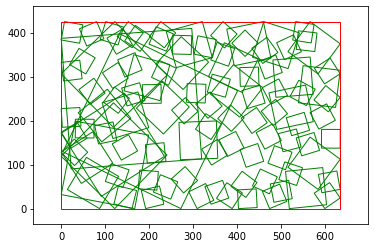

In [14]:
from matplotlib.patches import Rectangle
showSamples = np.transpose(np.array(samples))
fig, ax = plt.subplots()

rect_img =  Rectangle((0, 0),
                        width, height,
                        fc ='none', 
                        ec ='r',
                        lw = 1)

for i in range(len(samples)):
    x, y = samples[i]

    t_start = ax.transData
    t2 = matplotlib.transforms.Affine2D().rotate_deg_around(x,y, randomRotations[i] * 180 / np.pi)
    t =  t2 + t_start 

    rect =  Rectangle((x - patch_sizes[i]/2, y - patch_sizes[i]/2),
                        patch_sizes[i], patch_sizes[i],
                        fc ='none', 
                        ec ='g',
                        lw = 1, transform = t)

    ax.add_patch( rect )
   
ax.add_patch( rect_img )
ax.axis('equal')
plt.xlim([-width/10, width + width/10])
plt.ylim([-height/10, height + height/10])

plt.show()

The file names we created when generating the patch files got wrong, so let's rename them.

In [15]:
with os.scandir('spotgarbage-GINI-master\spotgarbage\patches') as it:
    for entry in it:
        name = str(PurePath(entry.name))
        parts = str(name).split(sep = '.')
        if len(parts) == 3:
            newName = parts[0] + parts[1][3:] + "." + parts[2]
            os.rename('spotgarbage-GINI-master\spotgarbage\patches\\' + name,'spotgarbage-GINI-master\spotgarbage\patches\\' + newName)
       
print('done')

done


In the above step more than 745.000 patch files where produced. We would like to delete randomly 245.000 of them leaving some 500.000 remaining. These should be divided into 250.000 garbage and 250.000 non-garbage patches. First lets count how many of each type we have.

In [17]:
GarbageNames = set()
paths = [y for x in os.walk('spotgarbage-GINI-master\spotgarbage\garbage-queried-images') for y in glob(os.path.join(x[0], '*.*'))]
for path in paths:
    pure = PurePath(path)
    GarbageNames.add(str(pure.name)[:-4])

NonGarbageNames = set()
paths = [y for x in os.walk('spotgarbage-GINI-master\spotgarbage\\non-garbage-queried-images') for y in glob(os.path.join(x[0], '*.*'))]
for path in paths:
    pure = PurePath(path)
    NonGarbageNames.add(str(pure.name)[:-4])

print(len(GarbageNames))
print(len(NonGarbageNames))

907
1602


In [18]:
garbageCounter = 0
NonGarbageCounter = 0
garbageList = []
nonGarbageList = []

#i = 0
with os.scandir('spotgarbage-GINI-master\spotgarbage\patches') as it:
    for entry in it:
        #i += 1
        name = str(PurePath(entry.name))
        parts = str(name).split(sep = '_')
        if (parts[0]) in GarbageNames:
            garbageCounter += 1
            garbageList.append(name)
        if (parts[0]) in NonGarbageNames:
            NonGarbageCounter += 1
            nonGarbageList.append(name)
        #print(parts[0])
        #if i == 10:
        #    break

print(garbageCounter) # 131272
print(NonGarbageCounter) # 604652
print(len(garbageList))
print(len(nonGarbageList))


131272
604652
131272
604652


In [19]:
deleteNonGarbageList = random.sample(nonGarbageList,len(nonGarbageList) - 130000)
deleteGarbageList = random.sample(garbageList,len(garbageList) - 130000)
print(len(deleteNonGarbageList))
print(len(deleteGarbageList))
deleteNonGarbageSet = set(deleteNonGarbageList)
deleteGarbageSet = set(deleteGarbageList)
print(len(deleteNonGarbageSet))
print(len(deleteGarbageSet))

474652
1272
474652
1272


Now that we have our two lists of items to delete, we carry on with the deleting

In [20]:
with os.scandir('spotgarbage-GINI-master\spotgarbage\patches') as it:
    for entry in it:
        name = str(PurePath(entry.name))
        
        if name in deleteNonGarbageSet:
            os.remove('spotgarbage-GINI-master\spotgarbage\patches\\' + name)

        if name in deleteGarbageSet:
            os.remove('spotgarbage-GINI-master\spotgarbage\patches\\' + name)

Find out if all files are indeed PNG files

In [21]:
i = 0
j = 0
with os.scandir('spotgarbage-GINI-master\spotgarbage\patches') as it:
    for entry in it:
        j += 1
        name = str(PurePath(entry.name))
        if name.endswith(".png"):
            i += 1

print(i,j)

269460 269460


For generating the 5 stratified folds in the paper we will need a simple table like structure for the patces, with patch name and class label. We store this in a simple CSV file.

In [25]:
#i = 0
with open('spotgarbage-GINI-master\spotgarbage\\train.csv', 'w', newline="") as csvfile, os.scandir('spotgarbage-GINI-master\spotgarbage\patches') as it:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['name','class'])
    for entry in it:
        #i += 1
        name = str(PurePath(entry.name))
        parts = str(name).split(sep = '_')
        if (parts[0]) in GarbageNames:
            writer.writerow([name,'garbage'])
        if (parts[0]) in NonGarbageNames:
            writer.writerow([name,'nongarbage'])
        #print(parts[0])
        #if i == 10:
        #    break
